# 1. Ground truth

## Import

* import numpy for matrix
* import matplotlib.pyplot for plotting
* import math for math function
* import random for random variable. Creating noise or start point etc

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import random

## Init constant value and other functions

In [2]:
objectNum = 5

startTime_Sec = 0
endTime_Sec = 10
dtObject = 0.005 # 5ms
dtLidar = 0.025 # 25ms
dtRadar = 0.050 # 50ms

TRAJECTORY = 1
X = 2
Y = 3

LidarNoiseSize = 2
RadarNoiseSize = 10 # 0 < RadarNoiseSize < 1000

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)

class Trajectory():
    def __init__ (self, times):
        self.x = np.zeros_like(times)
        self.y = np.zeros_like(times)
        self.rho = np.zeros_like(times)
        self.phi = np.zeros_like(times)

## Const accelerate equation

In [3]:
class Object():
    #def __init__ (self, times, x, y, ID, color):
        #self.color = color
    def __init__ (self, times, x, y, ID):
        self.ID = ID
        self.states = []
        self.trajectory = Trajectory(times)
        
        #state: x, y, x`, y`, x``, y``
        self.state_ca = np.matrix([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).T

        self.state_ca[0] = x
        self.state_ca[1] = y

        self.F = np.matrix([[1.0, 0.0, dtObject, 0.0, 1/2.0*dtObject**2, 0.0],
                         [0.0, 1.0, 0.0, dtObject, 0.0, 1/2.0*dtObject**2],
                         [0.0, 0.0, 1.0, 0.0, dtObject, 0.0],
                         [0.0, 0.0, 0.0, 1.0, 0.0, dtObject],
                         [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
        
        self.B = np.matrix([[0.0, 0.0],
                           [0.0, 0.0],
                           [0.0, 0.0],
                           [0.0, 0.0],
                           [1.0, 0.0],
                           [0.0, 1.0]])
    
    def getState(self, ax, ay):
        accel = np.matrix([ax, ay]).T
        self.state_ca = self.F*self.state_ca + self.B*accel
        
        return self.state_ca
        
        
    def subplots(self, times, axes, ID):
        
        axes[0].plot (self.trajectory.x, self.trajectory.y, color='red', label='Ground truth{0}'.format(ID))
        axes[1].plot (times, self.trajectory.x, color='red', label='Ground truth{0}'.format(ID))
        axes[2].plot (times, self.trajectory.y, color='red', label='Ground truth{0}'.format(ID))
        
        
    def plot (self, times, ID, pltType):
        if pltType == TRAJECTORY:
            plt.plot(self.trajectory.x, self.trajectory.y, color="red", linewidth=1.5, linestyle="-",label="Ground truth {0}".format(ID))
                
        elif pltType == X:
            plt.plot(times, self.trajectory.x, color="red", linewidth=1.5, linestyle="-",label="Ground truth {0}".format(ID))
                
        elif pltType == Y:
            plt.plot(times, self.trajectory.y, color="red", linewidth=1.5, linestyle="-",label="Ground truth {0}".format(ID))

## Creating object and getting object states

In [4]:
objects = []
times = np.linspace (startTime_Sec, endTime_Sec, int(endTime_Sec/dtObject))

# create object with random position
for objectIdx in range(objectNum):
    x = random.uniform(0.0, 1000.0)
    y = random.uniform(0.0, 1000.0)
    
    object = Object(times, x, y, objectIdx)
    objects.append(object)


# get object state
for objectIdx, object in enumerate(objects):
    for t in range(len(times)):
        accel = 0.0
        radian = 0.0
    
        if (t % 5) == 0:
            accel = random.uniform(-10.0, 10.0)
            radian = random.uniform(-math.pi, math.pi)
        
        state = object.getState(accel*math.cos(radian), accel*math.sin(radian))

        object.states.append(state)
        object.trajectory.x[t] = state[0, 0]
        object.trajectory.y[t] = state[1, 0]

# 2. Sensor model

### 2.1 Lidar model

In [5]:
class LiDAR():
    def __init__(self, times):
        self.measurements = []
        self.trajectory = Trajectory(times)
        self.H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                           [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])
            
            
    def measure(self, states):
        measurementIdx = 0
        
        for stateIdx, state in enumerate(states):
            
            # 25ms 
            if (stateIdx % (dtLidar/dtObject)) == 0:
                measurement = self.H*state

                # Noise
                sensor_noise = np.random.randn()*LidarNoiseSize
                measurement[0, 0] = measurement[0, 0] + sensor_noise
                
                sensor_noise = np.random.randn()*LidarNoiseSize
                measurement[1, 0] = measurement[1, 0] + sensor_noise
                
                self.measurements.append(measurement)
                self.trajectory.x[measurementIdx] = measurement[0, 0]
                self.trajectory.y[measurementIdx] = measurement[1, 0]
                
                measurementIdx = measurementIdx + 1
                
            else:
                continue
                
    def subplots(self, times, axes, ID):
        axes[0].plot (self.trajectory.x, self.trajectory.y, 'b.', markersize=4, label='Lidar{0}'.format(ID))
        axes[1].plot (times, self.trajectory.x, 'b.', markersize=4, label='Lidar{0}'.format(ID))
        axes[2].plot (times, self.trajectory.y, 'b.', markersize=4, label='Lidar{0}'.format(ID))
    
    
    def plot (self, times, ID, pltType):
        if pltType == TRAJECTORY:
            plt.plot(self.trajectory.x, self.trajectory.y, 'bo', markersize=4, label="Lidar {0}".format(ID))
                
        elif pltType == X:
            plt.plot(times, self.trajectory.x, 'bo', markersize=4, label="Lidar {0}".format(ID))
                
        elif pltType == Y:
            plt.plot(times, self.trajectory.y, 'bo', markersize=4, label="Lidar {0}".format(ID))

### 2.2 Radar model

In [6]:
class Radar():
    def __init__(self, times):
        self.measurements = []
        self.trajectory = Trajectory(times)

    def measure(self, states):

        measurement = np.matrix([0.0, 0.0, 0.0]).T                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
        measurementIdx = 0
        for stateIdx, state in enumerate(states):

            # 50ms
            if (stateIdx % (dtRadar/dtObject)) == 0:
                rho = math.sqrt(math.pow(state[0, 0], 2) + math.pow(state[1, 0], 2))
                phi = math.atan2(state[1, 0], state[0, 0])
                rhoRate = (state[0, 0]*state[2, 0] + state[1, 0]*state[3, 0])/rho

                # noise
                sensorNoise = np.random.randn() * math.pi * (RadarNoiseSize/1000)
                phi = phi + sensorNoise
                
                measurement[0, 0] = rho
                measurement[1, 0] = phi
                measurement[2, 0] = rhoRate
                
                self.measurements.append(measurement)
                self.trajectory.rho[measurementIdx] = rho
                self.trajectory.phi[measurementIdx] = phi
                self.trajectory.x[measurementIdx], self.trajectory.y[measurementIdx] = pol2cart(rho, phi)
                
                measurementIdx = measurementIdx + 1                            
                
            else:
                continue

                
    def subplots(self, times, axes, ID):
        axes[0].plot (self.trajectory.x, self.trajectory.y, 'g.', markersize=4, label='Radar{0}'.format(ID))
        axes[1].plot (times, self.trajectory.x, 'g.', markersize=4, label='Radar{0}'.format(ID))
        axes[2].plot (times, self.trajectory.y, 'g.', markersize=4, label='Radar{0}'.format(ID))
    
    
    def plot (self, times, ID, pltType):
        if pltType == TRAJECTORY:
            plt.plot(self.trajectory.x, self.trajectory.y, 'go', markersize=4, label="Radar {0}".format(ID))
                
        elif pltType == X:
            plt.plot(times, self.trajectory.x, 'go', markersize=4, label="Radar {0}".format(ID))
                
        elif pltType == Y:
            plt.plot(times, self.trajectory.y, 'go', markersize=4, label="Radar {0}".format(ID))

## Generate LiDAR measurement and Radar measurement

In [7]:
lidars = []
timesLidar = np.linspace (startTime_Sec, endTime_Sec, int(endTime_Sec/dtLidar))

radars = []
timesRadar = np.linspace (startTime_Sec, endTime_Sec, int(endTime_Sec/dtRadar))


for object in objects:
    lidar = LiDAR(timesLidar)
    lidar.measure(object.states)
    lidars.append(lidar)
    
    radar = Radar(timesRadar)
    radar.measure(object.states)
    radars.append(radar)

## Comparison ground truth with Radar

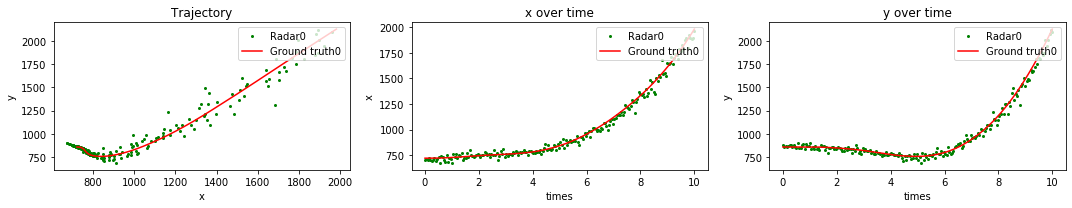

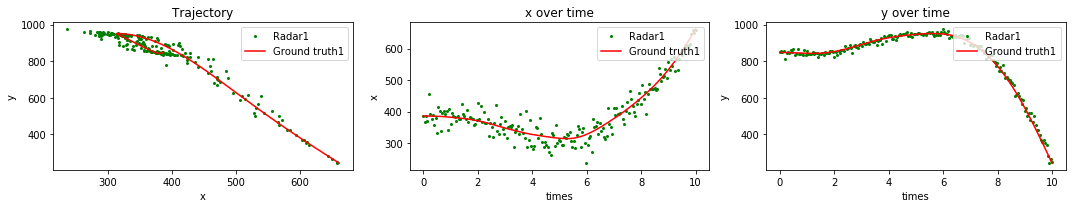

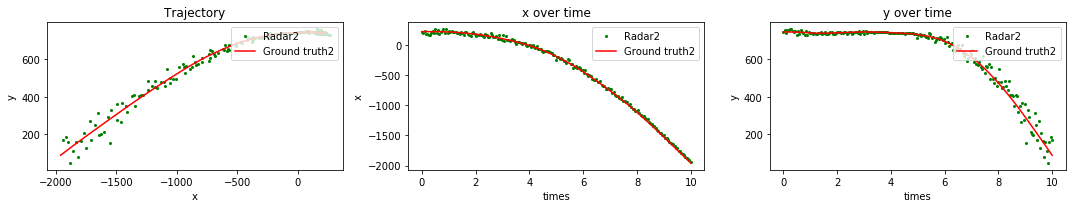

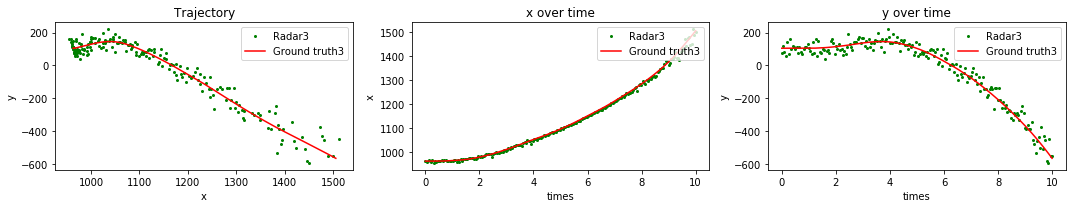

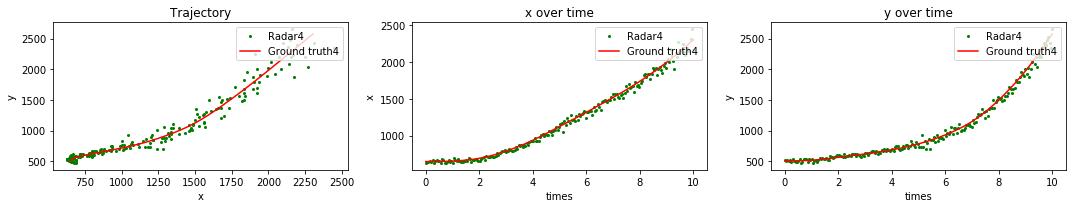

In [8]:
for Idx, radar in enumerate(radars):
    fig, axes = plt.subplots(1, 3, figsize = (15,3))
    radar.subplots(timesRadar, axes, Idx)
    objects[Idx].subplots(times, axes, Idx)
    
    axes[0].legend(loc="upper right")
    axes[0].set(xlabel = 'x', ylabel = 'y')
    axes[0].set_title('Trajectory')

    axes[1].legend(loc="upper right")
    axes[1].set(xlabel = 'times', ylabel = 'x')
    axes[1].set_title('x over time')

    axes[2].legend(loc="upper right")
    axes[2].set(xlabel = 'times', ylabel = 'y')
    axes[2].set_title('y over time')
    
    plt.tight_layout()
    plt.show()

Input radar number: 
0


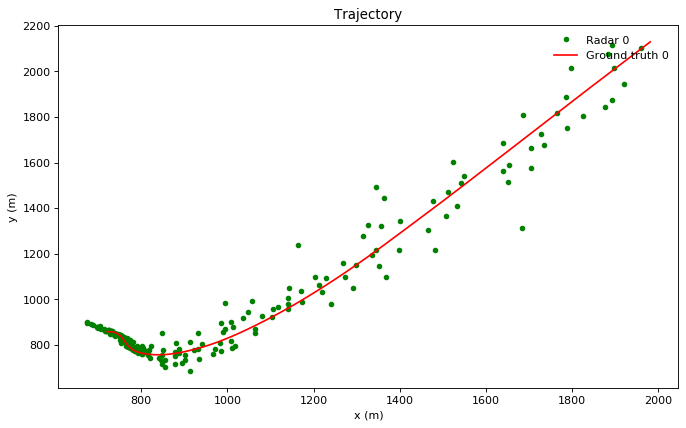

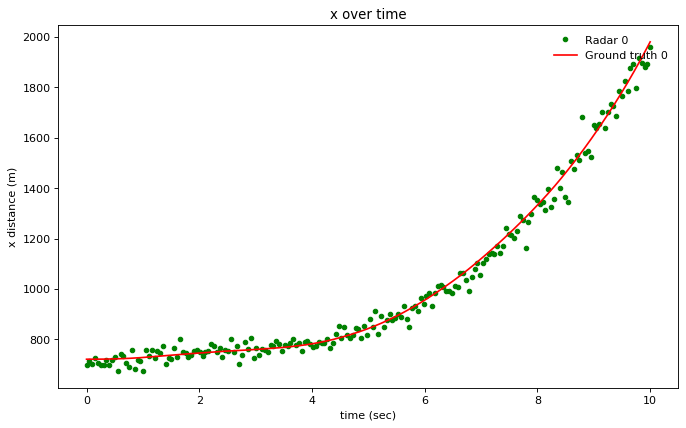

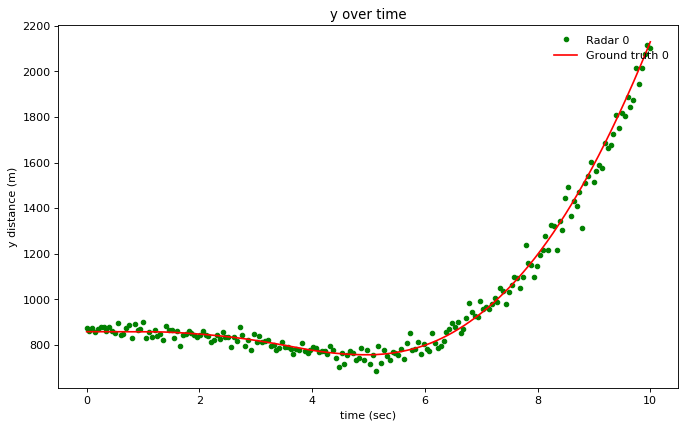

In [9]:
print ("Input radar number: ")
obj = int(input())

# Trajectory
plt.figure(figsize=(10,6), dpi=80)
plt.title("Trajectory")
radars[obj].plot (timesRadar, obj, TRAJECTORY)
objects[obj].plot (times, obj, TRAJECTORY)

plt.legend(loc='upper right', frameon=False)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

# x over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("x over time")
radars[obj].plot (timesRadar, obj, X)
objects[obj].plot (times, obj, X)

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('x distance (m)')
plt.show()

# y over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("y over time")
radars[obj].plot (timesRadar, obj, Y)
objects[obj].plot (times, obj, Y)

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('y distance (m)')
plt.show()

# 3. Tracking 

dt = 10 ms

## Kalman Filter

In [10]:
dtTracking = 0.01 # 10ms


def calculateJacobian (state):
    px = state[0, 0]; py = state[1, 0]
    vx = state[2, 0]; vy = state[3, 0]
    ax = state[4, 0]; ay = state[5, 0]
    
    rhoDpx = px/math.sqrt(px**2 + py**2)
    rhoDpy = py/math.sqrt(px**2 + py**2)
    rhoDvx = 0; rhoDvy = 0
    rhoDax = 0; rhoDay = 0
    
    phiDpx = -py/(px**2 + py**2)
    phiDpy = px/(px**2 + py**2)
    phiDvx = 0; phiDvy = 0
    phiDax = 0; phiDay = 0
    
    rhoRateDpx = py*(vx*py - vy*px)/((px**2 + py**2)**(3/2))
    rhoRateDpy = px*(vy*px - vx*py)/((px**2 + py**2)**(3/2))
    rhoRateDvx = px/math.sqrt(px**2 + py**2)
    rhoRateDvy = py/math.sqrt(px**2 + py**2)
    rhoRateDax = 0; rhoRateDay = 0
    
    H = np.matrix([[rhoDpx, rhoDpy, rhoDvx, rhoDvy, rhoDax, rhoDay],
                  [phiDpx, phiDpy, phiDvx, phiDvy, phiDax, phiDay],
                  [rhoRateDpx, rhoRateDpy, rhoRateDvx, rhoRateDvy, rhoRateDax, rhoRateDay]])
    
    return H

def h (state):
    px = state[0, 0]
    py = state[1, 0]
    vx = state[2, 0]
    vy = state[3, 0]

    rho = math.sqrt(px**2 + py**2)
    phi = math.atan2(py, px)
    rhoRate = (px*vx + py*vy)/rho
    
    x = np.matrix([rho, phi, rhoRate]).T
    
    return x

In [11]:
class KalmanFilter():
    def __init__(self, x, y, varState, varMeas):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
        self.x = np.matrix([x, y, 0.0, 0.0, 0.0, 0.0]).T
        
        self.initCovar = 10*np.eye(6)
        self.P = self.initCovar
        
        self.F = np.matrix([[1.0, 0.0, dtTracking, 0.0, 1/2.0*dtTracking**2, 0.0],
                         [0.0, 1.0, 0.0, dtTracking, 0.0, 1/2.0*dtTracking**2],
                         [0.0, 0.0, 1.0, 0.0, dtTracking, 0.0],
                         [0.0, 0.0, 0.0, 1.0, 0.0, dtTracking],
                         [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
        
        # Process model                     
        a = 0.5 * dtTracking**2
        b = dtTracking
        c = 1.0
        # varState = 1000.0 # sigma x = sigma y
        self.Q = np.matrix([[a*a*varState, 0.0, a*b*varState, 0.0, a*c*varState, 0.0],
                         [0.0, a*a*varState, 0.0, a*b*varState, 0.0, a*c*varState],
                         [a*b*varState, 0.0, b*b*varState, 0.0, b*c*varState, 0.0],
                         [0.0, a*b*varState, 0.0, b*b*varState, 0.0, b*c*varState],
                         [a*c*varState, 0.0, b*c*varState, 0.0, c*c*varState, 0.0],
                         [0.0, a*c*varState, 0.0, b*c*varState, 0.0, c*c*varState]])
        
        self.H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])
        
        # varMeas = 10.0
        self.R = np.matrix([[varMeas, 0.0],
                           [0.0, varMeas]])

        self.Rj = np.matrix([[varMeas, 0.0, 0.0],
                            [0.0, varMeas, 0.0],
                            [0.0, 0.0, varMeas]])

        
    def predict (self):
        self.x = self.F * self.x
        self.P = self.F * self.P * self.F.T + self.Q
    
    def updateKF (self, z):
        e = z - self.H*self.x
        S = self.H*self.P*self.H.T + self.R
        K = self.P*self.H.T*np.linalg.pinv(S)

        self.x = self.x + K*e
        self.P = self.P - K*S*K.T
            
    def updateEKF (self, z):
        Hj = calculateJacobian (self.x)
        e = z - h(self.x)
        
        while (e[1, 0] > math.pi or e[1, 0] < -math.pi):
            if e[1, 0] > math.pi:
                e[1, 0] = e[1, 0] - math.pi
            else:
                e[1, 0] = e[1, 0] + math.pi
        
        S = Hj*self.P*Hj.T + self.Rj
        K = self.P*Hj.T*np.linalg.pinv(S)

        self.x = self.x + K*e
        self.P = self.P - K*S*K.T 

In [12]:
class Tracking ():

    def __init__ (self, times, x, y, ID, varState, varMeas):
        self.states = []
        self.trajectory = Trajectory(times)
        self.filter = KalmanFilter(x, y, varState, varMeas)
        self.varState = varState
        self.varMeas = varMeas
        
                
    def subplots(self, times, axes, ID):
        axes[0].plot (self.trajectory.x, self.trajectory.y, 'm.', markersize=4, label='Tracking{0}'.format(ID))
        axes[1].plot (times, self.trajectory.x, 'm.', markersize=4, label='Tracking{0}'.format(ID))
        axes[2].plot (times, self.trajectory.y, 'm.', markersize=4, label='Tracking{0}'.format(ID))
    
    
    def plot (self, times, ID, pltType, color):
        if pltType == TRAJECTORY:
            plt.plot(self.trajectory.x, self.trajectory.y, '{0}o'.format(color), markersize=4, label="Tracking {0}, v_s={1}, v_m={2}".format(ID, self.varState, self.varMeas))
                
        elif pltType == X:
            plt.plot(times, self.trajectory.x, '{0}o'.format(color), markersize=4, label="Tracking {0}, v_s={1}, v_m={2}".format(ID, self.varState, self.varMeas))
                
        elif pltType == Y:
            plt.plot(times, self.trajectory.y, '{0}o'.format(color), markersize=4, label="Tracking {0}, v_s={1}, v_m={2}".format(ID, self.varState, self.varMeas))

In [15]:
print ("Input track number: ")
obj = int(input())

dt = 0.005 # 5ms, tracking, emasurement 최소공배수
timesShared = np.linspace (startTime_Sec, endTime_Sec, int (endTime_Sec/dt))
timesTracking = np.linspace (startTime_Sec, endTime_Sec, int (endTime_Sec/dtTracking))


varPx = np.zeros (len (timesTracking))
varPy = np.zeros (len (timesTracking))
varVx = np.zeros (len (timesTracking))
varVy = np.zeros (len (timesTracking))
varAx = np.zeros (len (timesTracking))
varAy = np.zeros (len (timesTracking))


# object initial pose range: 0 ~ 1000 -> track initial pose 500
trackRadar = Tracking(timesTracking, objects[obj].states[0][0, 0], objects[obj].states[0][1, 0], obj, varState = 1000.0, varMeas = 1000.0)

RadarIdx = 0
trackingIdx = 0

for t in range (len (timesShared)):
    
    # 50ms
    if (t % int (dtRadar/dt) == 0):
        z = radars[obj].measurements[RadarIdx]
        trackRadar.filter.updateEKF(z)
        
        RadarIdx = RadarIdx + 1
    
    # 10ms
    elif  (t % int (dtTracking/dt) == 0):
        trackRadar.filter.predict()
        
    else:
        continue
        
    # 10ms
    if (t % int (dtTracking/dt) == 0):
        trackRadar.states.append(trackRadar.filter.x)
        trackRadar.trajectory.x[trackingIdx] = trackRadar.filter.x[0, 0]
        trackRadar.trajectory.y[trackingIdx] = trackRadar.filter.x[1, 0]
        
        varPx[trackingIdx] = trackRadar.filter.P[0, 0]
        varPy[trackingIdx] = trackRadar.filter.P[1, 1]
        varVx[trackingIdx] = trackRadar.filter.P[2, 2]
        varVy[trackingIdx] = trackRadar.filter.P[3, 3]
        varAx[trackingIdx] = trackRadar.filter.P[4, 4]
        varAy[trackingIdx] = trackRadar.filter.P[5, 5]
        
        trackingIdx = trackingIdx + 1

Input track number: 
0


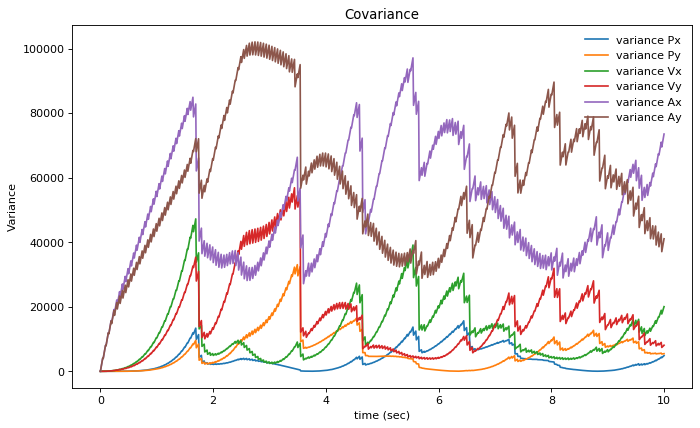

In [18]:
# Tracking plot
plt.figure(figsize=(10,6), dpi=80)
plt.title("Covariance")
plt.plot (timesTracking, varPx, label='variance Px')
plt.plot (timesTracking, varPy, label='variance Py')
plt.plot (timesTracking, varVx, label='variance Vx')
plt.plot (timesTracking, varVy, label='variance Vy')
plt.plot (timesTracking, varAx, label='variance Ax')
plt.plot (timesTracking, varAy, label='variance Ay')

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('Variance')

plt.show()

## Plot comparing Lidar Tracking with Lidar measurement

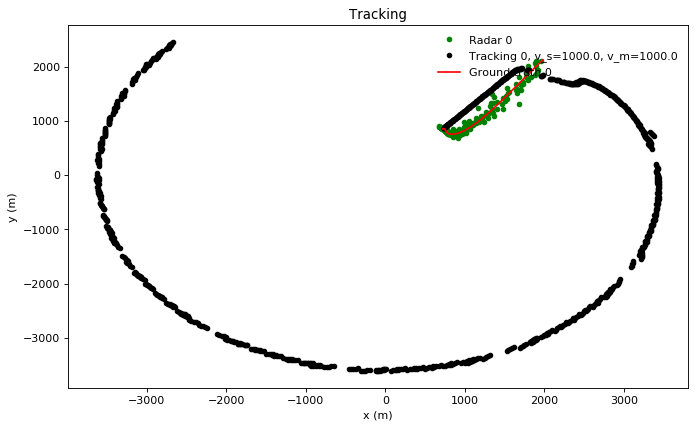

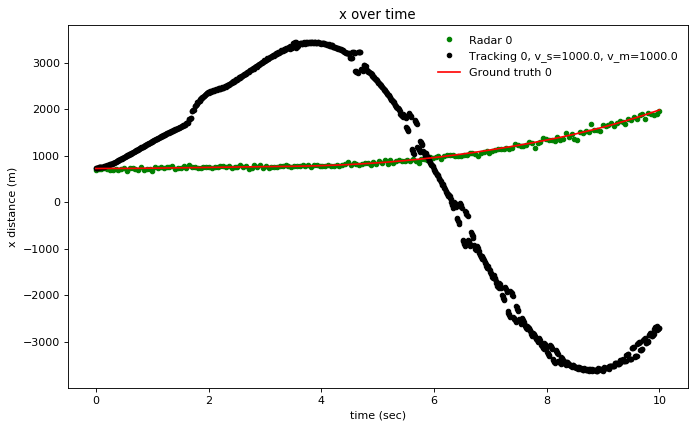

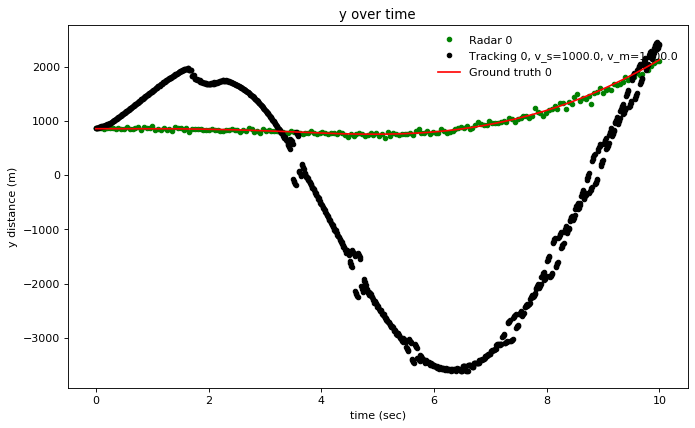

In [17]:
# Tracking plot
plt.figure(figsize=(10,6), dpi=80)
plt.title("Tracking")
radars[obj].plot (timesRadar, obj, TRAJECTORY)
trackRadar.plot (timesTracking, obj, TRAJECTORY, 'k')
objects[obj].plot (times, obj, TRAJECTORY)

plt.legend(loc='upper right', frameon=False)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

# x over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("x over time")
radars[obj].plot (timesRadar, obj, X)
trackRadar.plot (timesTracking, obj, X, 'k')
objects[obj].plot (times, obj, X)

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('x distance (m)')
plt.show()

# y over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("y over time")
radars[obj].plot (timesRadar, obj, Y)
trackRadar.plot (timesTracking, obj, Y, 'k')
objects[obj].plot (times, obj, Y)

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('y distance (m)')
plt.show()